# YOLOv11 Segmentation Inference & Basic Comparison

This notebook demonstrates basic inference using a pre-trained YOLOv11 segmentation model,
loads data from the VOC dataset, stores results systematically, and performs simple
quantitative and visual comparisons between predictions and ground truth.

## 1. Setup

Import necessary libraries.

In [1]:
import os
import random
from collections import Counter

import cv2  # Make sure opencv-python is installed
import matplotlib.pyplot as plt
import numpy as np  # Make sure numpy is installed
from dotenv import load_dotenv
from ultralytics import YOLO

# Ensure plots are displayed inline in notebooks if run there
%matplotlib inline

print("Libraries imported.")


Libraries imported.


## 2. Load Pre-trained Model

In [2]:
model_name = "yolo11n-seg.pt"
model = YOLO(model_name)
print(f"Loaded model: {model_name}")

# Define class names for VOC (adjust if using a different dataset)
# Based on standard VOC order
VOC_CLASS_NAMES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

# Define colors for visualization (20 classes)
# Using tab20 colormap for distinct colors
COLORS = plt.cm.tab20(np.linspace(0, 1, 20))
# Convert to BGR for OpenCV (0-255)
CV_COLORS = [(int(c[2] * 255), int(c[1] * 255), int(c[0] * 255)) for c in COLORS]

Loaded model: yolo11n-seg.pt


## 3. Prepare Data from VOC Dataset

Load images and corresponding ground truth label paths from the specified VOC split.
Store paths and results in a dictionary keyed by image basename.

In [5]:
# --- Configuration ---
split = "val2007"  # Options: 'train2007', 'val2007', 'train2012', 'val2012'
num_samples = 8  # Number of random images to process

# Load .env file to get dataset path
project_root_for_env = os.path.abspath(
    os.path.join(os.getcwd(), "../../..")
)  # Adjust depth if needed
dotenv_path = os.path.join(project_root_for_env, ".env")
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path)
    # print(f"Loaded environment variables from: {dotenv_path}")

VOC_SEGMENT_PATH = os.getenv("VOC_SEGMENT")
print(f"VOC segment is at {VOC_SEGMENT_PATH}")

# Prepare image and label files
image_dir = os.path.join(VOC_SEGMENT_PATH, "images", split)
label_dir = os.path.join(VOC_SEGMENT_PATH, "labels", split)
assert os.path.isdir(image_dir) and os.path.isdir(label_dir)

all_image_files = [
    f for f in os.listdir(image_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))
]
if len(all_image_files) >= num_samples:
    selected_image_files = random.sample(all_image_files, num_samples)
else:
    selected_image_files = all_image_files
print(f"Prepared {len(selected_image_files)} images")

VOC segment is at /home/ubuntu/vibe/hub/datasets/VOC/segment
Prepared 8 images


In [8]:
# Load data into a dictionary
data_dict = {}
for img_file in selected_image_files:
    basename = os.path.splitext(img_file)[0]
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, basename + ".txt")

    if os.path.exists(img_path) and os.path.exists(label_path):
        data_dict[basename] = {
            "image_path": img_path,
            "label_path": label_path,
            "prediction": None,  # Placeholder for results
        }
    else:
        print(f"Skipping {basename}, missing file.") # Keep it cleaner for notebook

print(f"Prepared data for {len(data_dict)} images from VOC '{split}' split:")
for i, (basename, data) in enumerate(data_dict.items()):
    print(
        f"  {i + 1}. ID: {basename}, Image: {data['image_path']}, Label: {data['label_path']}"
    )

Prepared data for 8 images from VOC 'val2007' split:
  1. ID: 000661, Image: /home/ubuntu/vibe/hub/datasets/VOC/segment/images/val2007/000661.jpg, Label: /home/ubuntu/vibe/hub/datasets/VOC/segment/labels/val2007/000661.txt
  2. ID: 005210, Image: /home/ubuntu/vibe/hub/datasets/VOC/segment/images/val2007/005210.jpg, Label: /home/ubuntu/vibe/hub/datasets/VOC/segment/labels/val2007/005210.txt
  3. ID: 001225, Image: /home/ubuntu/vibe/hub/datasets/VOC/segment/images/val2007/001225.jpg, Label: /home/ubuntu/vibe/hub/datasets/VOC/segment/labels/val2007/001225.txt
  4. ID: 003178, Image: /home/ubuntu/vibe/hub/datasets/VOC/segment/images/val2007/003178.jpg, Label: /home/ubuntu/vibe/hub/datasets/VOC/segment/labels/val2007/003178.txt
  5. ID: 009687, Image: /home/ubuntu/vibe/hub/datasets/VOC/segment/images/val2007/009687.jpg, Label: /home/ubuntu/vibe/hub/datasets/VOC/segment/labels/val2007/009687.txt
  6. ID: 003848, Image: /home/ubuntu/vibe/hub/datasets/VOC/segment/images/val2007/003848.jpg, Lab

## 4. Run Inference

Run YOLOv11 segmentation prediction on the selected images and store results.

In [9]:
image_paths_to_predict = [data["image_path"] for data in data_dict.values()]
print(f"\nRunning prediction on {len(image_paths_to_predict)} images...")

results = model.predict(
    source=image_paths_to_predict, save=False, save_txt=False
)  # Don't save automatically now

pred_cnt, miss_cnt = 0, 0
# Store results back into the dictionary, assuming order is preserved
basenames = list(data_dict.keys())
for i, result in enumerate(results):
    basename = os.path.splitext(os.path.basename(result.path))[0]
    if basename in data_dict:
        data_dict[basename]["prediction"] = result
        pred_cnt += 1
    else: # Fallback if basenames don't match somehow (shouldn't happen)
        print(f"Warning: Basename {basename} not found in data_dict. Skipping result.")
        miss_cnt += 1

print(f"\nTotal predictions: {pred_cnt}, Missed: {miss_cnt}\n")

# Example: Access prediction for the first image
first_key = list(data_dict.keys())[0]
print(f"\nDisplay prediction for: {first_key}")
print(data_dict[first_key]['prediction'])


Running prediction on 8 images...

0: 640x640 2 chairs, 1 couch, 1 potted plant, 11.4ms
1: 640x640 1 bowl, 1 tv, 1 mouse, 1 keyboard, 1 book, 1 clock, 11.4ms
2: 640x640 1 dog, 1 chair, 11.4ms
3: 640x640 1 train, 11.4ms
4: 640x640 2 persons, 1 bottle, 11.4ms
5: 640x640 1 train, 11.4ms
6: 640x640 1 dog, 11.4ms
7: 640x640 3 cars, 1 bus, 1 fire hydrant, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 70.8ms postprocess per image at shape (1, 3, 640, 640)

Total predictions: 8, Missed: 0


Display prediction for: 000661
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'b

## 5. Quantitative Comparison (Object Counts)

Compare the number of detected objects per class in the prediction vs. the ground truth.

In [10]:
def parse_yolo_segment_label_counts(label_path):
    """Parses a YOLO segmentation label file and returns class counts."""
    counts = Counter()
    if not os.path.exists(label_path):
        return counts
    try:
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 1:
                    class_id = int(parts[0])
                    counts[class_id] += 1
    except Exception as e:
        print(f"Error parsing label file {label_path}: {e}")
    return counts


print("\n--- Quantitative Comparison (Class Counts) ---")

for basename, data in data_dict.items():
    print(f"\nImage ID: {basename}")

    lbl_counts = parse_yolo_segment_label_counts(data["label_path"])
    lbl_counts_named = {
        VOC_CLASS_NAMES[cid]: count
        for cid, count in lbl_counts.items()
        if cid < len(VOC_CLASS_NAMES)
    }



    prediction = data.get("prediction")
    assert prediction and prediction.boxes and prediction.names

    pred_counts = Counter()
    pred_class_indices = prediction.boxes.cls.int().tolist()
    pred_class_names = [prediction.names[i] for i in pred_class_indices]
    pred_counts.update(pred_class_names)

    print(f"  Labeled: {lbl_counts_named}")
    print(f"  Predicted: {dict(pred_counts)}")


--- Quantitative Comparison (Class Counts) ---

Image ID: 000661
  Labeled: {'sofa': 1, 'pottedplant': 1, 'chair': 1}
  Predicted: {'couch': 1, 'chair': 2, 'potted plant': 1}

Image ID: 005210
  Labeled: {'tvmonitor': 1}
  Predicted: {'tv': 1, 'keyboard': 1, 'mouse': 1, 'clock': 1, 'bowl': 1, 'book': 1}

Image ID: 001225
  Labeled: {'dog': 1}
  Predicted: {'dog': 1, 'chair': 1}

Image ID: 003178
  Labeled: {'train': 1}
  Predicted: {'train': 1}

Image ID: 009687
  Labeled: {'person': 2, 'bottle': 2}
  Predicted: {'person': 2, 'bottle': 1}

Image ID: 003848
  Labeled: {'train': 1}
  Predicted: {'train': 1}

Image ID: 003872
  Labeled: {'dog': 1}
  Predicted: {'dog': 1}

Image ID: 008747
  Labeled: {'bus': 1, 'car': 1}
  Predicted: {'bus': 1, 'fire hydrant': 1, 'car': 3}


## 6. Visual Comparison (Segmentation Masks)

Visualize the original image, the ground truth segmentation, and the predicted segmentation side-by-side.


--- Visual Comparison --- (GT vs. Prediction)

Visualizing: 000661


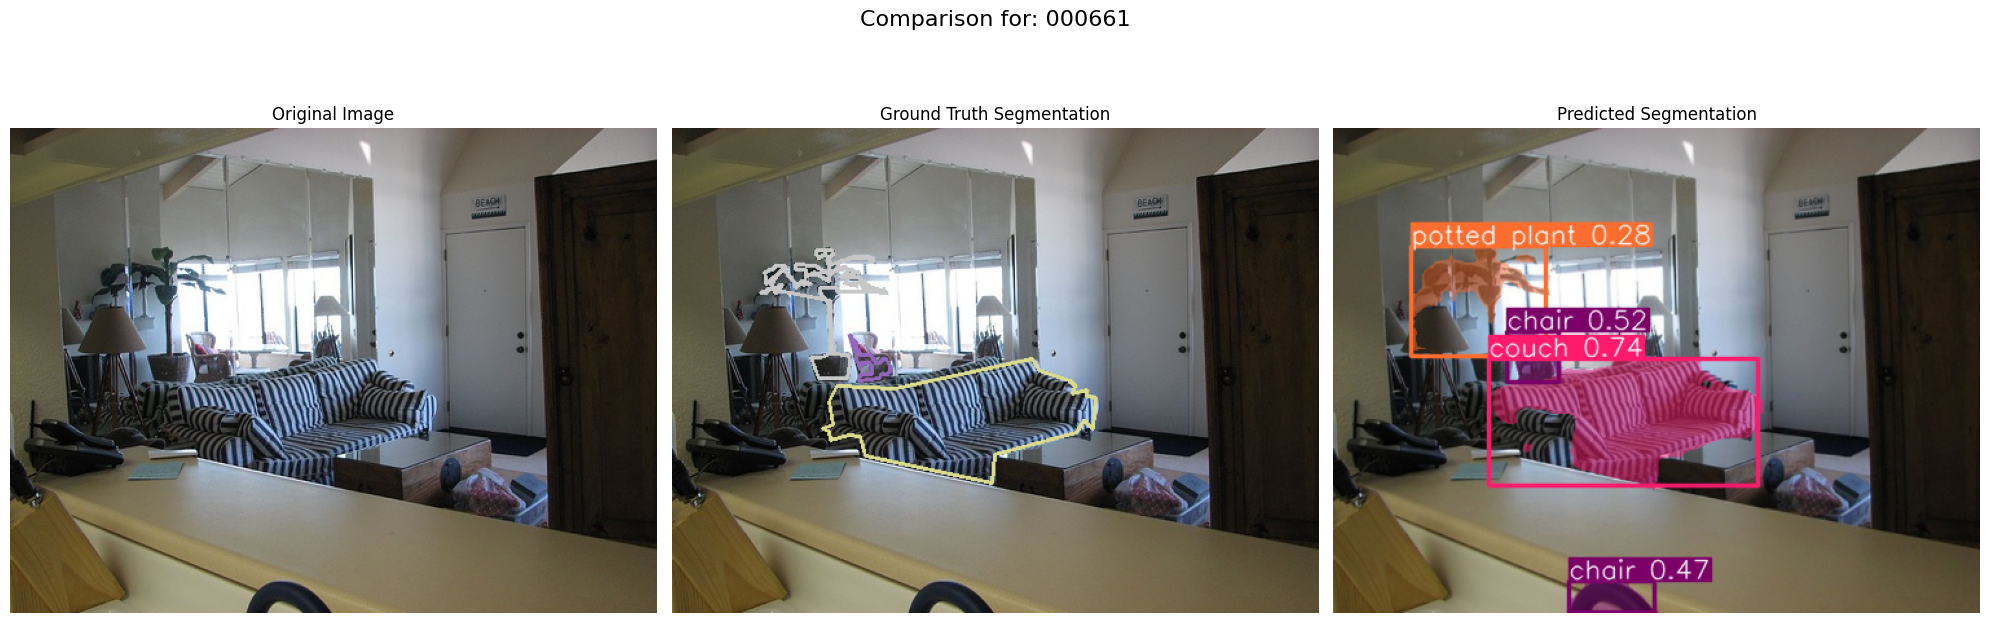


Visualizing: 005210


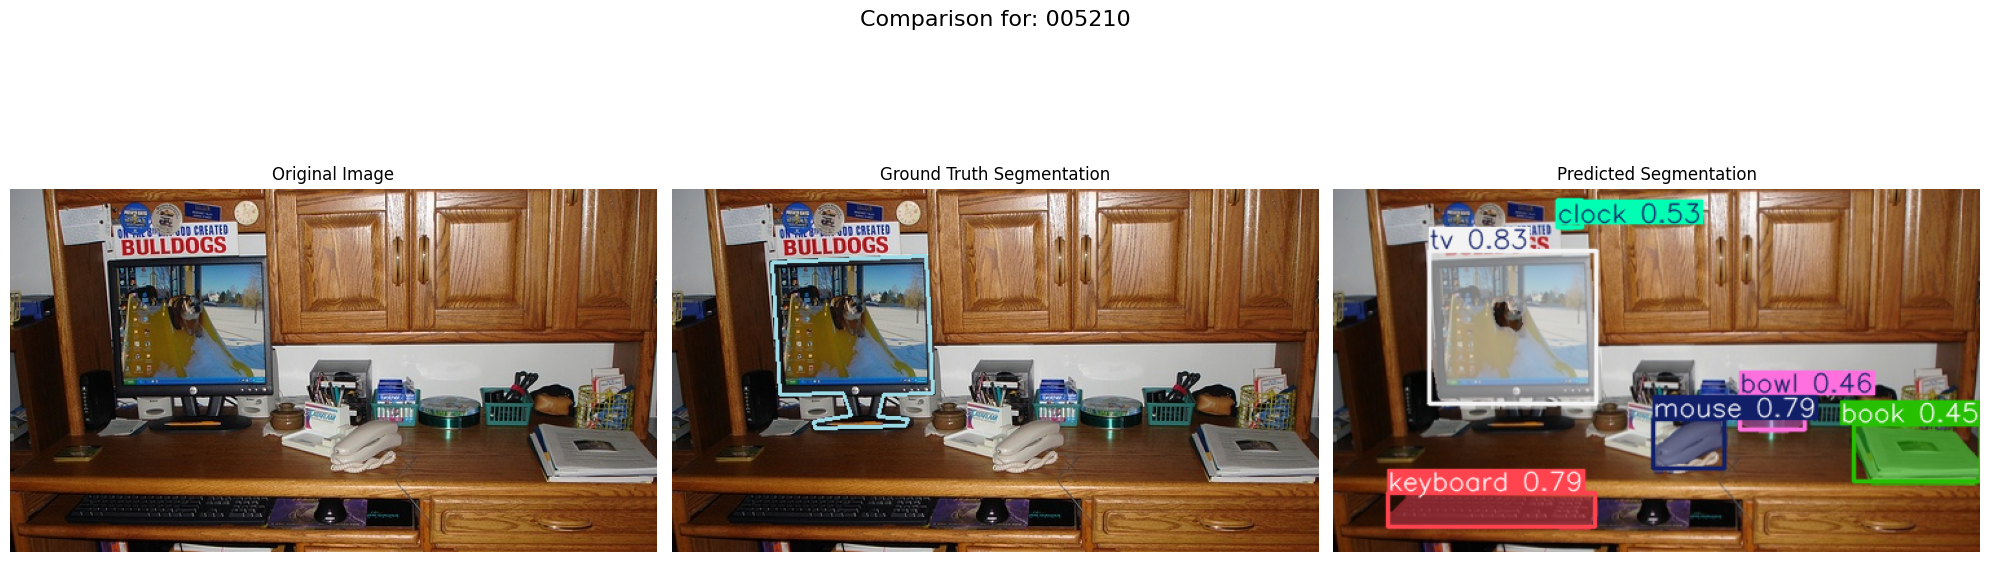


Visualizing: 001225


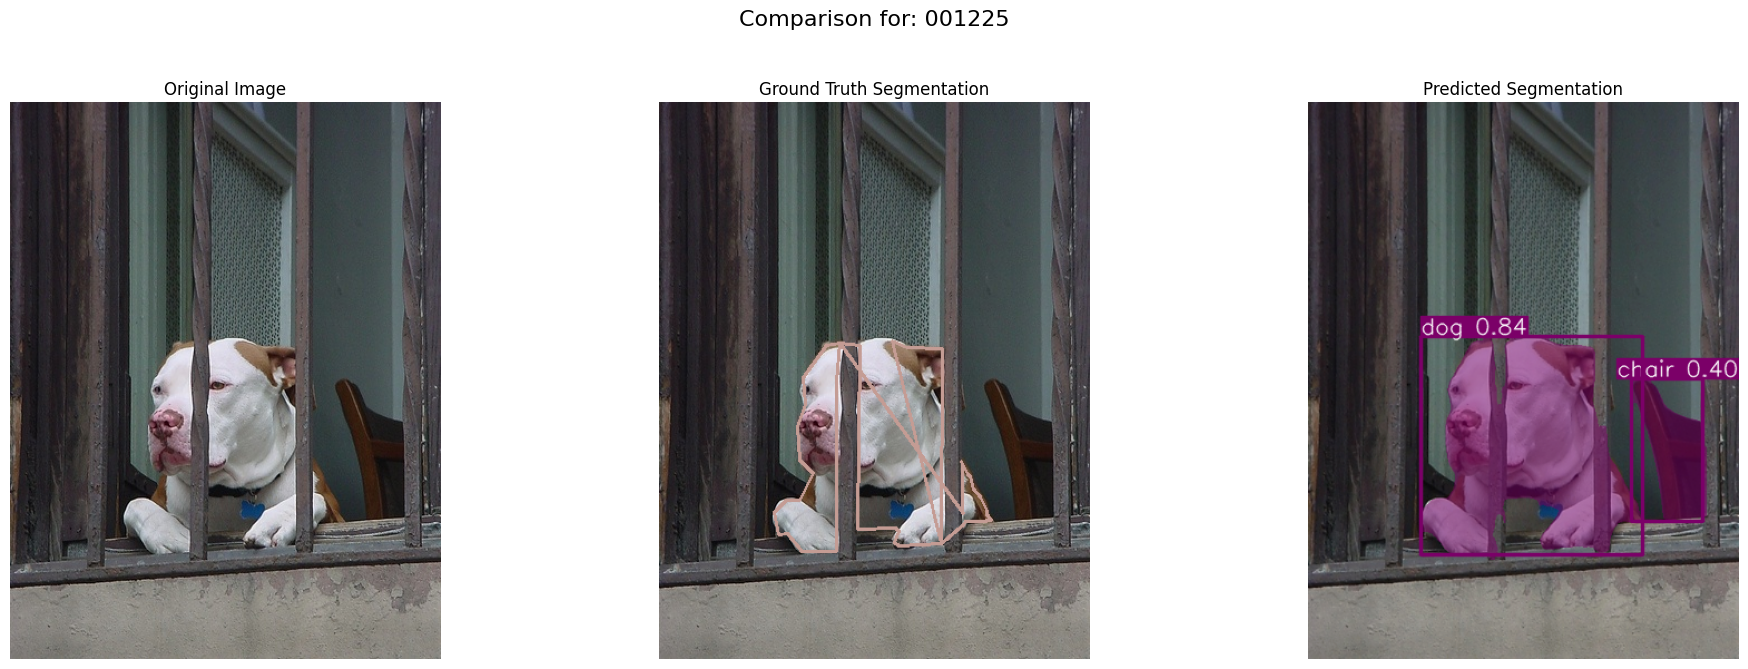


Visualizing: 003178


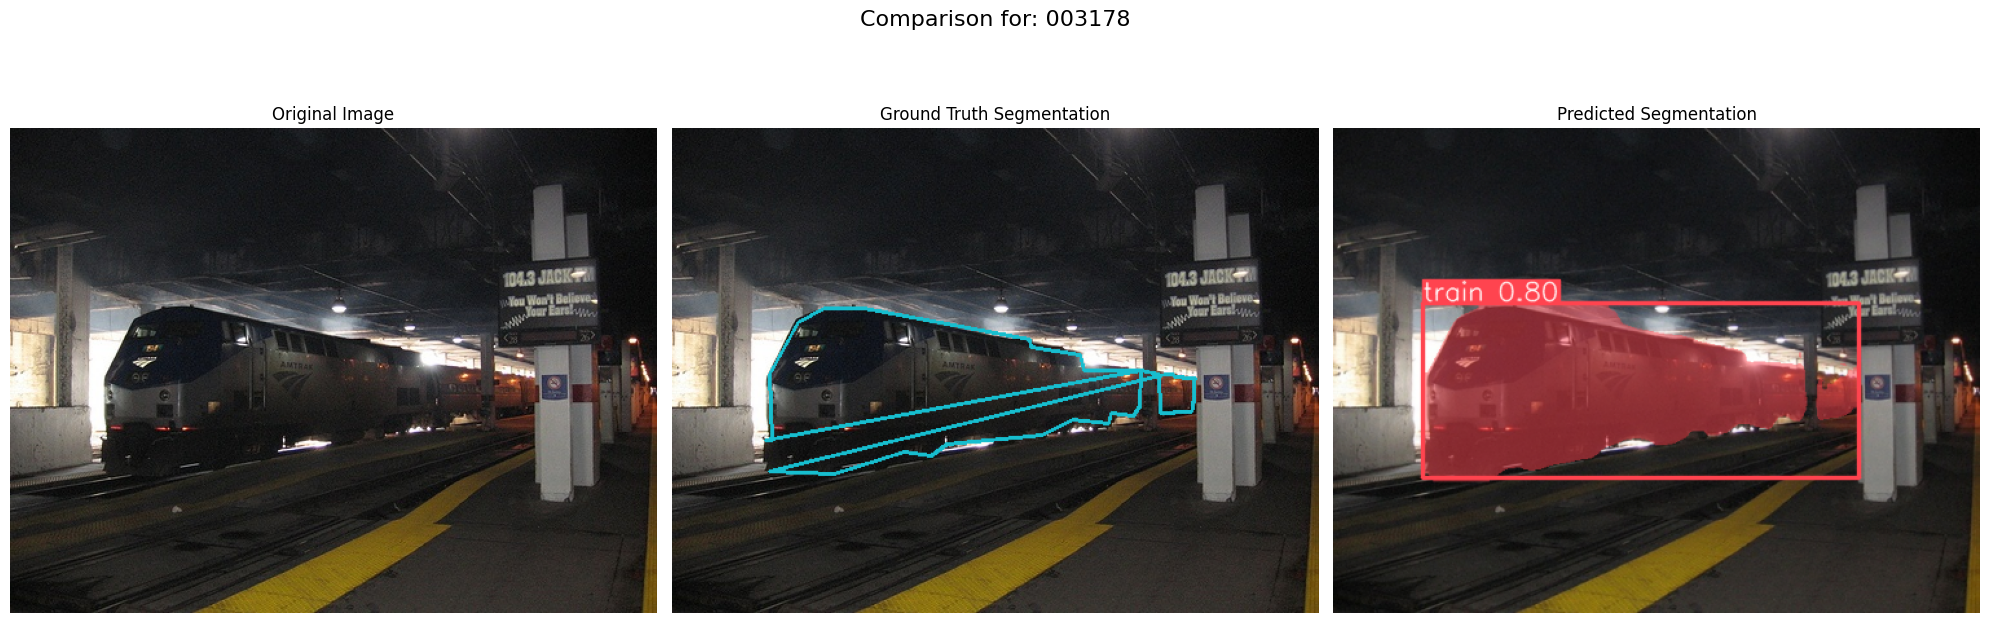


Visualizing: 009687


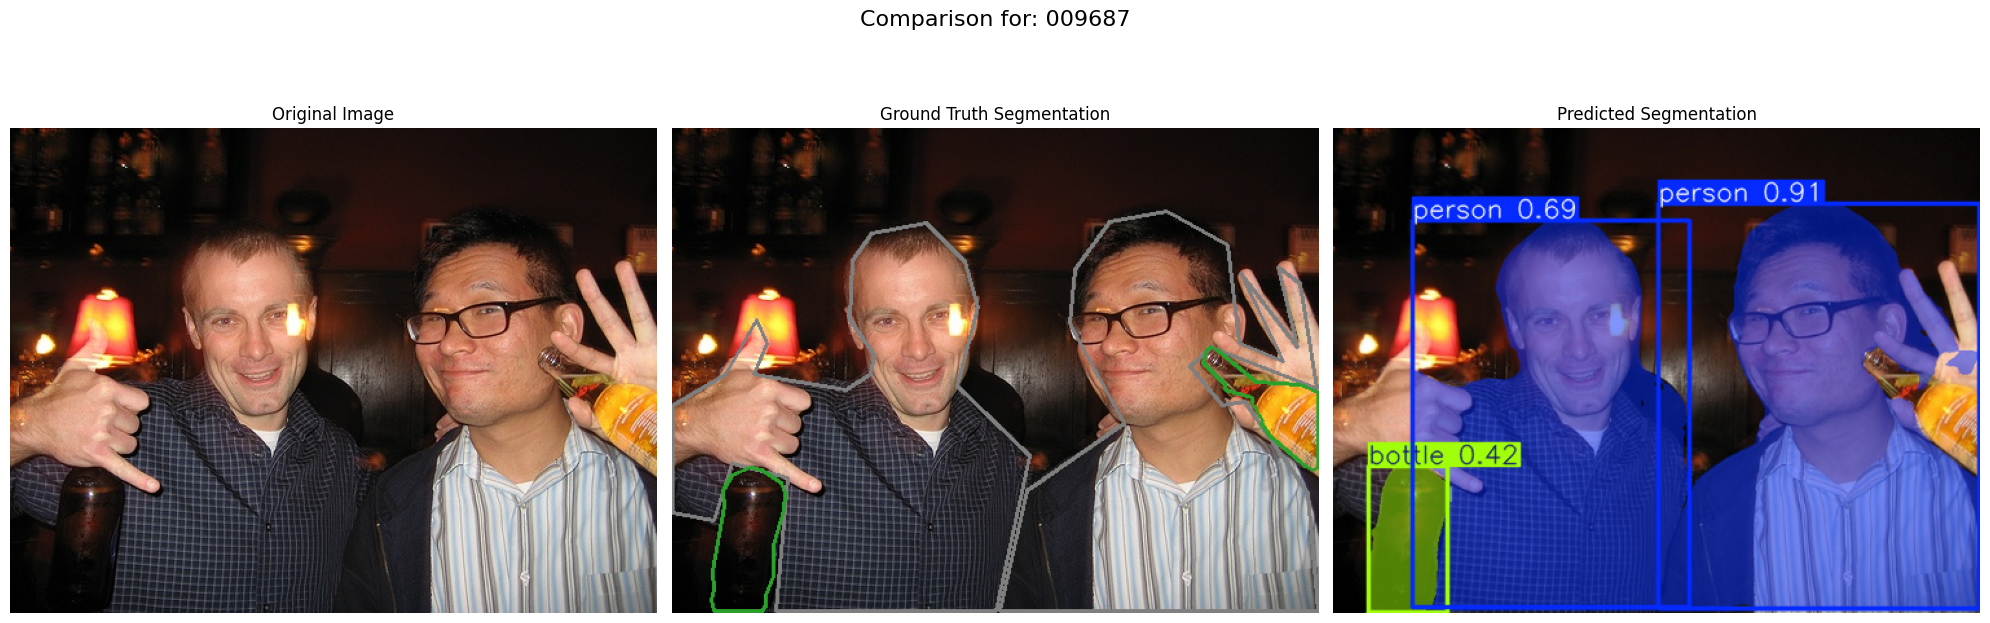


Visualizing: 003848


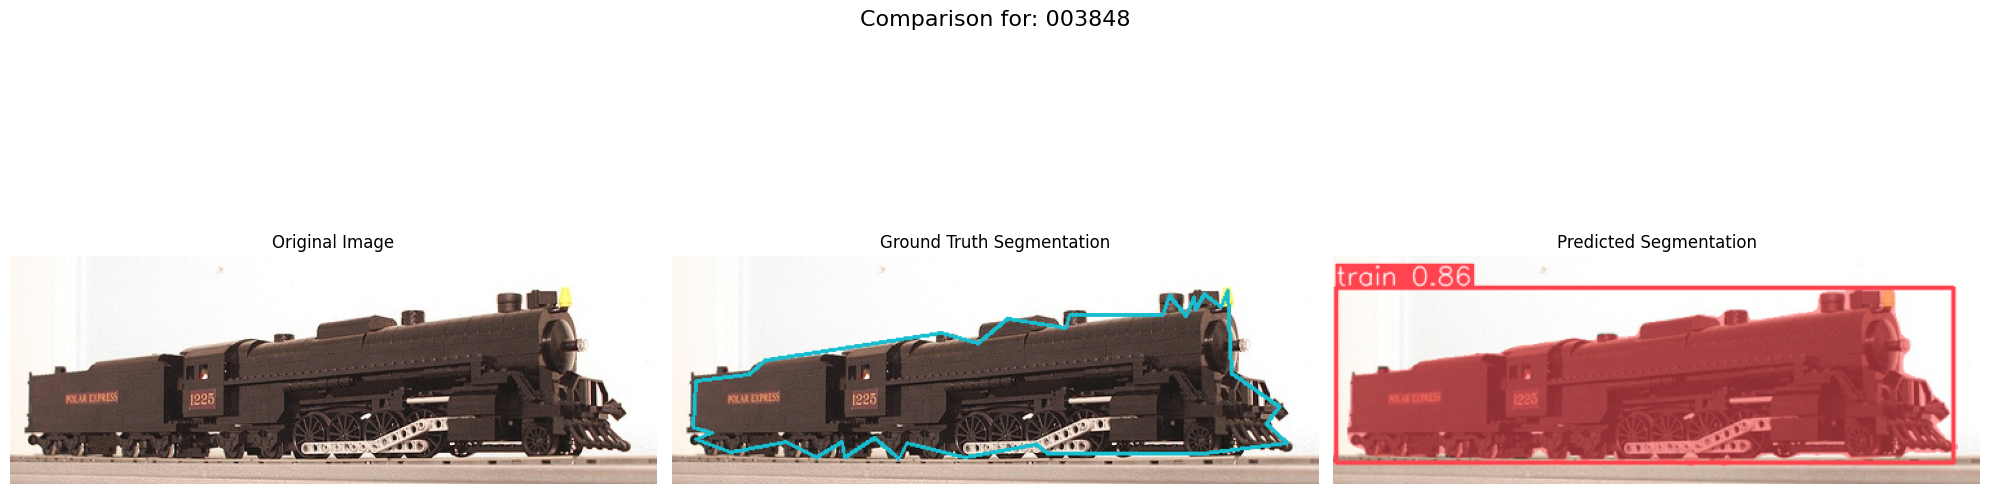


Visualizing: 003872


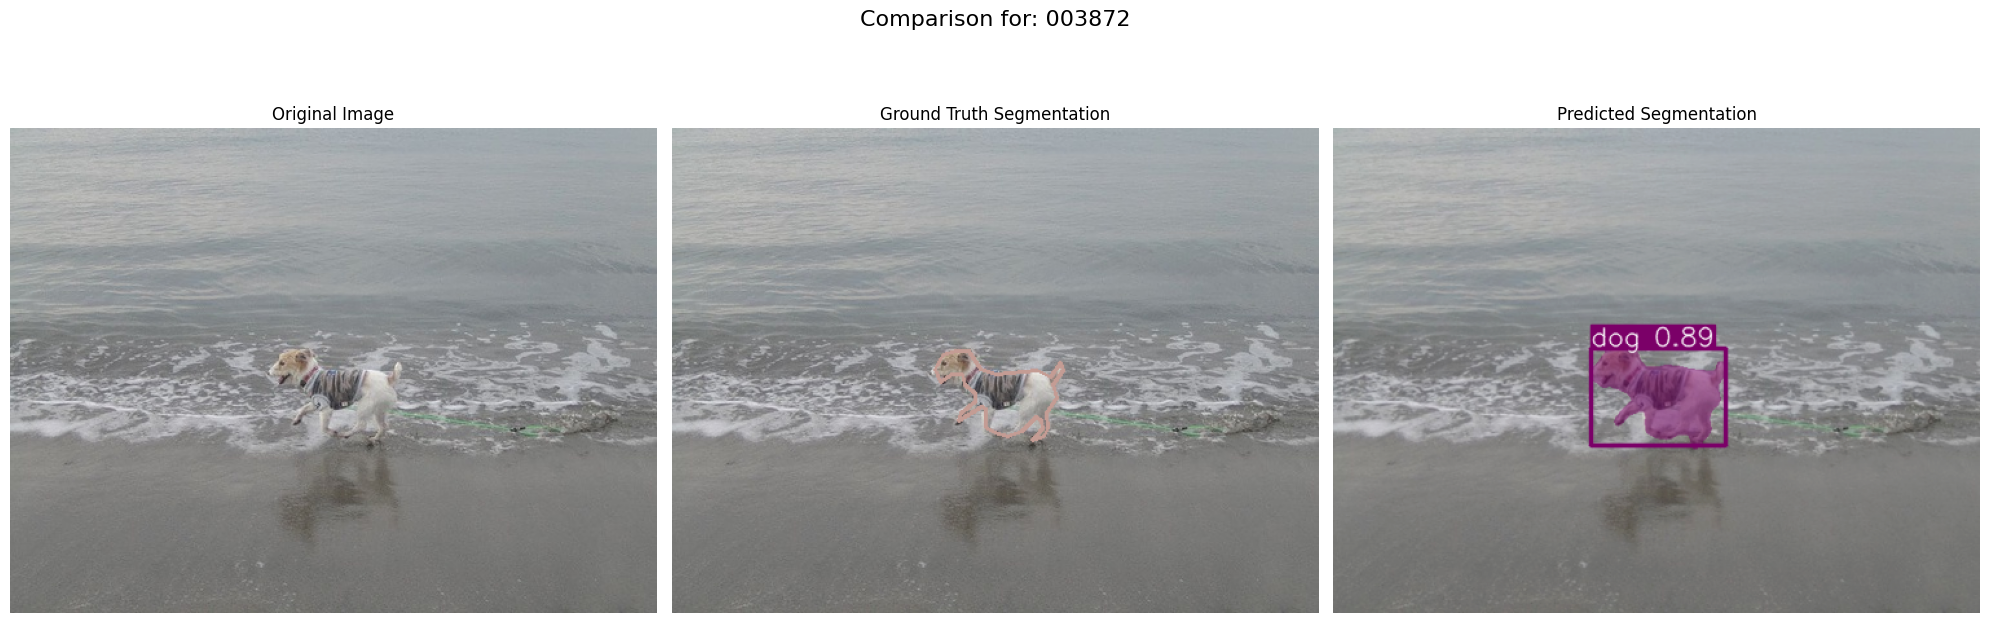


Visualizing: 008747


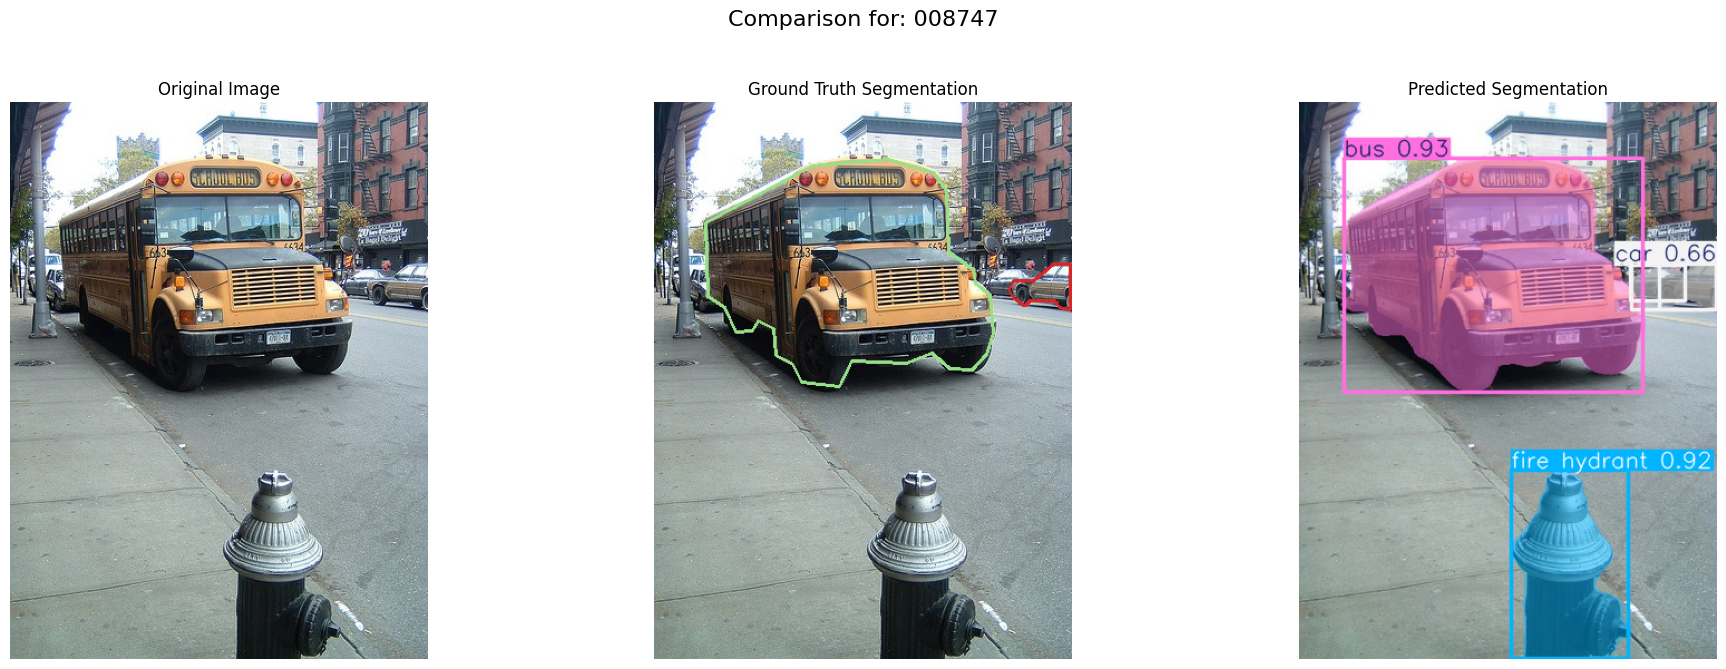

In [11]:
def draw_gt_segmentation(image_path, label_path):
    """Reads image and label file, draws GT segmentation polygons."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error reading image: {image_path}")
        return None
    h, w = img.shape[:2]
    img_draw = img.copy()

    if not os.path.exists(label_path):
        return img_draw  # Return original image if no label file

    try:
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 7:  # class_id + at least 3 points (x,y pairs)
                    class_id = int(parts[0])
                    poly_norm = np.array(parts[1:], dtype=float).reshape(-1, 2)
                    poly_denorm = (poly_norm * np.array([w, h])).astype(int)

                    color = CV_COLORS[
                        class_id % len(CV_COLORS)
                    ]  # Cycle through colors if more classes than defined
                    # Draw filled polygon (optional, can be visually noisy)
                    # cv2.fillPoly(img_draw, [poly_denorm], color)
                    # Draw polygon outline
                    cv2.polylines(img_draw, [poly_denorm], isClosed=True, color=color, thickness=2)
                    # Put class name text (optional)
                    # label_pos = tuple(poly_denorm.min(axis=0))
                    # cv2.putText(img_draw, VOC_CLASS_NAMES[class_id], label_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    except Exception as e:
        print(f"Error drawing GT for {label_path}: {e}")

    return img_draw


print("\n--- Visual Comparison --- (GT vs. Prediction)")

for basename, data in data_dict.items():
    print(f"\nVisualizing: {basename}")
    img_path = data["image_path"]
    label_path = data["label_path"]
    prediction = data.get("prediction")

    # Read original image
    img_original = cv2.imread(img_path)
    if img_original is None:
        continue
    img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # Generate GT visualization
    img_gt = draw_gt_segmentation(img_path, label_path)
    img_gt_rgb = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB) if img_gt is not None else img_original_rgb

    # Generate prediction visualization
    if prediction:
        img_pred_array = prediction.plot()  # Returns annotated image as BGR numpy array
        img_pred_rgb = cv2.cvtColor(img_pred_array, cv2.COLOR_BGR2RGB)
    else:
        img_pred_rgb = np.copy(img_original_rgb)
        cv2.putText(
            img_pred_rgb, "No Prediction", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
        )

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle(f"Comparison for: {basename}", fontsize=16)

    axes[0].imshow(img_original_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(img_gt_rgb)
    axes[1].set_title("Ground Truth Segmentation")
    axes[1].axis("off")

    axes[2].imshow(img_pred_rgb)
    axes[2].set_title("Predicted Segmentation")
    axes[2].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent title overlap
    plt.show()

## 7. Conclusion

This notebook demonstrated loading a pre-trained YOLOv11 segmentation model, running inference on data from the VOC dataset, and performing basic quantitative (class counts) and visual (side-by-side masks) comparisons against ground truth labels.